# Optimal feature clustering - Part III
> Feature clustering finds several applications in finance: portfolio construction, feature selection, regime detection, etc. In part I of this series,

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy, Feature Selection, Variation of Information, Correlation Distance]
- image: images/post_image_optimal_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

In [49]:
######################################## Part I
from fcmeans import FCM

def cluster(n_clusters, features, random_state=42):
    # membership probabilities
    model = FCM(n_clusters=n_clusters, random_state=random_state, max_iter=1000, error=1e-9).fit(features)
    p = model.u
    # representative cluster
    representative_cluster = np.argmax(p, 1)
    # membership entropy
    Sx = -np.sum(p*np.log(p), 1) / np.log(n_clusters)
    # total membership entropy (across the entire feature space)
    S = np.sum(Sx)        
    
    return p, representative_cluster, Sx, S

######################################## Part II
def calculate_corr_distance_1side(X, Y):
    rho = np.corrcoef(np.array((X, Y)))[0,1]
    distance = np.sqrt(1-np.abs(rho))
    return distance

def calculate_entropy(X):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram(X, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6    
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_joint_entropy(X, Y):
    # 1) Histograms the samples
    nbins = int(len(X)**(1/3))
    p = np.histogram2d(X, Y, bins=nbins, density=False)[0]
    p = p/np.sum(p)+1e-6
    # 2) Calculates the entropy
    entropy = -np.sum(p*np.log2(p))
    
    return entropy

def calculate_mutual_information(X, Y):
    S_X = calculate_entropy(X)
    S_Y = calculate_entropy(Y)
    S_XY = calculate_joint_entropy(X, Y)
    I = S_X+S_Y-S_XY
    return I

def calculate_variation_of_information(X, Y):
    I = calculate_mutual_information(X, Y)
    S = calculate_joint_entropy(X, Y)
    distance = 1 - I/S
    
    return distance

## Experimental results

In [2]:
import numpy as np

(n,k,m) n features, k clusters, at least m features per cluster

In [3]:
def construct_random_partition(n, k, m, seed=None):
    rand = np.random.RandomState(seed=seed)
    parts = rand.choice(range(1, n-k*(m-1)), k-1, replace=False)
    parts.sort()
    parts = np.append(parts, n-k*(m-1))
    parts = np.append(parts[0], np.diff(parts)) - 1 + m
    
    return parts

In [4]:
out = construct_random_partition(n=10, k=4, m=2, seed=42)
print(out)

[3 2 3 2]


Generates datasets

In [30]:
from scipy.stats import norm

n = 50
k = 10
m = 2

n_observations = 10000
sigma = 0.4

def generate_realization(n, k, m, n_observations, sigma, seed=None):
    dataset = list()
    partition = construct_random_partition(n=n, k=k, m=m, seed=seed)
    for value in partition:
        base_sample = norm.rvs(size=(1, n_observations))[0,:]
        [dataset.append(base_sample+sigma*norm.rvs(size=(1, n_observations))[0,:]) for i in range(0, value)]
    return np.transpose(np.array(dataset))
        
        
        
    

In [31]:
dataset = generate_realization(n=n, k=k, m=m, n_observations=n_observations, sigma=sigma, seed=40)

In [32]:
import pandas as pd






def calculate_distance_matrices(dataset):
    n = dataset.shape[1]
    distance_corr_1side = np.zeros((n, n))
    distance_variation_of_info = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            distance_corr_1side[i,j] = calculate_corr_distance_1side(X=dataset[:,i], Y=dataset[:,j])
            distance_variation_of_info[i,j] = calculate_variation_of_information(X=dataset[:,i], Y=dataset[:,j])
    return (distance_corr_1side, distance_variation_of_info)

                                                                    


In [33]:
correlation_matrix = pd.DataFrame(dataset).corr()
correlation_distance_matrix, variation_info_distance_matrix = calculate_distance_matrices(dataset)

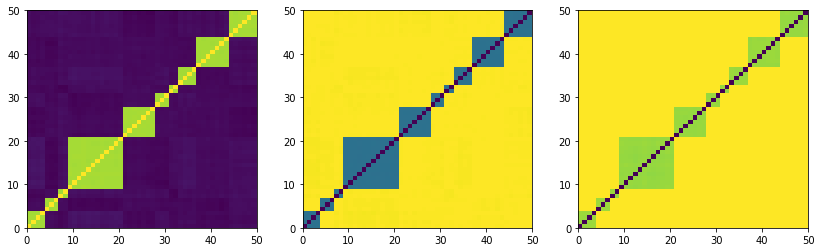

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].pcolor(correlation_matrix)
#axes[0].colorbar()
axes[1].pcolor(correlation_distance_matrix)
#axes[1].colorbar()
axes[2].pcolor(variation_info_distance_matrix)
#axes[1].colorbar()
plt.show()

In [35]:
dataset = dataset[:, np.random.permutation(dataset.shape[1])]



### Dimensionality reduction

In [77]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(correlation_distance_matrix)

explained_variance_ratio = pca.explained_variance_ratio_


In [78]:
DIMENSIONALITY_REDUCTION = True

if DIMENSIONALITY_REDUCTION:
    observation_matrix = PCA(n_components=2).fit_transform(variation_info_distance_matrix)
else:
    observation_matrix = variation_info_distance_matrix

In [79]:
n_clusters_trials = np.arange(2, 15, 1)
total_entropies = list()
for trial in n_clusters_trials:
    _, _, _, total_entropy = cluster(n_clusters=trial, features=observation_matrix, random_state=20)
    total_entropies.append(total_entropy)

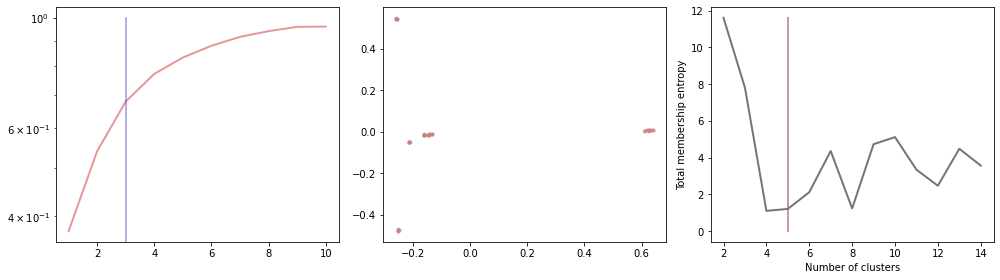

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))


axes[0].plot(np.linspace(1,10,10), np.cumsum(explained_variance_ratio), color=(0.8,0.2,0.2,0.5), linewidth=2)
axes[0].plot([3,3], [0,1], color=(0.2,0.2,0.8,0.5))
axes[0].set_yscale("log")

axes[1].plot(observation_matrix[:,0], observation_matrix[:,1], '.', color=(0.8,0.5,0.5,0.5))

axes[2].plot([5, 5], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
axes[2].plot(n_clusters_trials, total_entropies, color=(0.46,0.46,0.46), linewidth=2)
axes[2].set_xlabel('Number of clusters', )
axes[2].set_ylabel('Total membership entropy')

plt.tight_layout()
plt.show()

**Cluster quality**

In [81]:
p, representative_cluster, Sx, S = cluster(n_clusters=4, features=observation_matrix)

Si = list()
for clust in set(representative_cluster):
    probs = p[np.argmax(p, 1)==clust, :]
    entropy = -np.sum(probs*np.log(probs), 1) / np.log(probs.shape[1])
    Si.append(np.mean(entropy))
    
_=[print("Mean membership entropy across cluster {0} = {1}".format(i, np.round(Si[i], 3))) for i in range(0, len(Si))]

Mean membership entropy across cluster 0 = 0.0
Mean membership entropy across cluster 1 = 0.0
Mean membership entropy across cluster 2 = 0.045
Mean membership entropy across cluster 3 = 0.002


In [83]:
np.mean(Si)

0.011946506737059399

Initialize fcmeans with different seeds the do statistics would probably help

As suggested in Prado 2020, we can calculate cluster quality and rerun cluster for the subsuf of clusters of lower quality

Important observation:

In the case of linear relationships, PCA can be used (taking the dataset as input) and a way to discover the number of clusters, which will be the number of relevant principal components

In this construction, by construction the features in each cluster are uncorrelated with the features in the other clusters, which simplifies things a lot

**References:**

{% bibliography --cited %}